In [8]:
from readlif.reader import LifFile
lif_file = LifFile(r"D:\Box Sync\confocal\retina\immunos\66\isl2_calret_brn3c\immuno fixation duration test.lif")

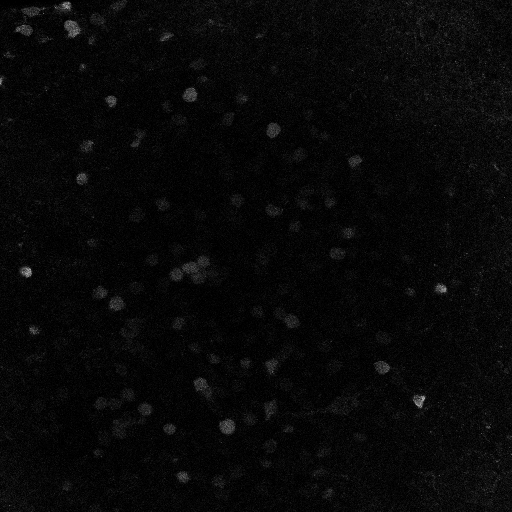

In [39]:
image_0 = lif_file.get_image(0)
test_img = image_0.get_frame(z=10, t=0, c=2, m=0)
test_img_arr = np.array(test_img)
test_img

In [41]:
test_img_arr

array([[ 0,  0,  0, ..., 13, 10, 13],
       [ 0,  0,  0, ..., 13, 10, 16],
       [ 0,  0,  0, ..., 27,  3, 16],
       ...,
       [ 3,  3,  6, ..., 13,  6, 20],
       [ 6, 10, 10, ...,  6,  6, 10],
       [ 6,  3,  0, ..., 20, 13, 16]], shape=(512, 512), dtype=uint8)

In [ ]:
from readlif.reader import LifFile
import os
from PIL import Image
import numpy as np
import tifffile

def convert_lif_to_tiff_hyperstack(lif_file_path, output_base_dir):
    """
    Convert a LIF file to multipage TIFF files organized by image and tile.
    Each TIFF is saved as a proper hyperstack with separate dimensions for 
    channels and z-slices that ImageJ can directly recognize.
    
    Args:
        lif_file_path (str): Path to the LIF file
        output_base_dir (str): Base directory to save the output
    """
    # Load the LIF file
    lif_file = LifFile(lif_file_path)
    
    # Get the filename without extension for naming the output folders
    file_name = os.path.splitext(os.path.basename(lif_file_path))[0]
    base_output_dir = os.path.join(output_base_dir, file_name)
    
    # Process each image in the LIF file
    for image_idx in range(lif_file.num_images):
        # Get the image
        image = lif_file.get_image(image_idx)
        
        # Create a directory for this image
        image_name = image.name if image.name else f"Image_{image_idx}"
        image_dir = os.path.join(base_output_dir, image_name)
        os.makedirs(image_dir, exist_ok=True)
        
        # Get the number of channels
        num_channels = image.channels
        
        print(f"Processing Image {image_idx}: {image_name}")
        print(f"  Dimensions: z={image.dims.z}, t={image.dims.t}, channels={num_channels}, m={image.dims.m}")
        
        # Process each mosaic tile
        for m in range(image.dims.m):
            try:
                print(f"  Processing tile {m}")
                
                # First, get sample frame to determine dimensions
                sample_frame = None
                for z in range(image.dims.z):
                    for c in range(num_channels):
                        try:
                            sample_frame = image.get_frame(z=z, t=0, c=c, m=m)
                            if sample_frame is not None:
                                break
                        except Exception:
                            pass
                    if sample_frame is not None:
                        break
                
                if sample_frame is None:
                    print(f"  Warning: Could not get any valid frames for tile {m}")
                    continue
                
                # Get dimensions from sample frame
                width, height = sample_frame.size
                
                # Debug: print frame size
                print(f"  Frame size: {width} x {height}")
                
                # Create a list to collect images for each channel and z-slice
                channels_data = []
                
                # For each channel
                for c in range(num_channels):
                    channel_frames = []
                    
                    # For each z-slice
                    for z in range(image.dims.z):
                        try:
                            # Get the frame for this specific channel and z-slice
                            frame = image.get_frame(z=z, t=0, c=c, m=m)
                            
                            # Convert to numpy array and add to channel data
                            frame_array = np.array(frame)
                            channel_frames.append(frame_array)
                        except Exception as e:
                            print(f"  Warning: Error processing z={z}, c={c}, m={m}: {e}")
                            # Create an empty frame with the same dimensions
                            empty_frame = np.zeros((height, width), dtype=np.uint8)
                            channel_frames.append(empty_frame)
                    
                    # Stack all z-slices for this channel
                    if channel_frames:
                        channel_stack = np.stack(channel_frames)
                        channels_data.append(channel_stack)
                
                # Check if we have data for all channels
                if len(channels_data) != num_channels:
                    print(f"  Warning: Expected {num_channels} channels but got {len(channels_data)}")
                
                # Stack all channels to create the final hyperstack
                # This should be a 4D array: [channels, z-slices, height, width]
                if channels_data:
                    hyperstack = np.stack(channels_data)
                    
                    # Reshape to [z, c, y, x] for ImageJ
                    # ImageJ expects TZCYX order with T=1
                    hyperstack = np.transpose(hyperstack, (1, 0, 2, 3))
                    
                    # Define output file path
                    tiff_filename = f"tile_{m}_hyperstack.tiff"
                    tiff_path = os.path.join(image_dir, tiff_filename)
                    
                    # Debug: print hyperstack shape
                    print(f"  Hyperstack shape: {hyperstack.shape}")
                    
                    # Save as a proper hyperstack with ImageJ metadata
                    tifffile.imwrite(
                        tiff_path, 
                        hyperstack, 
                        imagej=True,
                        metadata={
                            'axes': 'ZCYX',
                            'channels': num_channels,
                            'slices': image.dims.z
                        }
                    )
                    print(f"  Saved {tiff_path} as hyperstack with {image.dims.z} z-slices × {num_channels} channels")
                    
            except Exception as e:
                print(f"  Error processing tile {m}: {e}")

if __name__ == "__main__":
    # Example usage
    lif_file_path = r"D:\Box Sync\confocal\retina\immunos\66\isl2_calret_brn3c\immuno fixation duration test.lif"
    output_base_dir = r"D:\Output"  # Change this to your desired output directory
    
    convert_lif_to_tiff_hyperstack(lif_file_path, output_base_dir)

Processing Image 0: 15min
  Dimensions: z=188, t=1, channels=4, m=1
  Processing tile 0
  Frame size: 512 x 512
  Hyperstack shape: (188, 4, 512, 512)
  Saved D:\Output\immuno fixation duration test\15min\tile_0_hyperstack.tiff as hyperstack with 188 z-slices × 4 channels
Processing Image 1: 30 min
  Dimensions: z=176, t=1, channels=4, m=1
  Processing tile 0
  Frame size: 512 x 512
  Hyperstack shape: (176, 4, 512, 512)
  Saved D:\Output\immuno fixation duration test\30 min\tile_0_hyperstack.tiff as hyperstack with 176 z-slices × 4 channels
